Dataset Information:
Shape: (41000, 17)
Target distribution: Stroke
0    36849
1     4151
Name: count, dtype: int64
Target distribution (%): Stroke
0    89.87561
1    10.12439
Name: proportion, dtype: float64

Train set target distribution: Stroke
0    29479
1     3321
Name: count, dtype: int64
Test set target distribution: Stroke
0    7370
1     830
Name: count, dtype: int64
Before SMOTE: Counter({0: 29479, 1: 3321})
After SMOTE: Counter({0: 29479, 1: 29479})

Training XGBoost model...

XGBOOST PERFORMANCE
Accuracy: 0.7390
Precision: 0.0982
Recall: 0.1928
F1-Score: 0.1301

Confusion Matrix:
[[5900 1470]
 [ 670  160]]


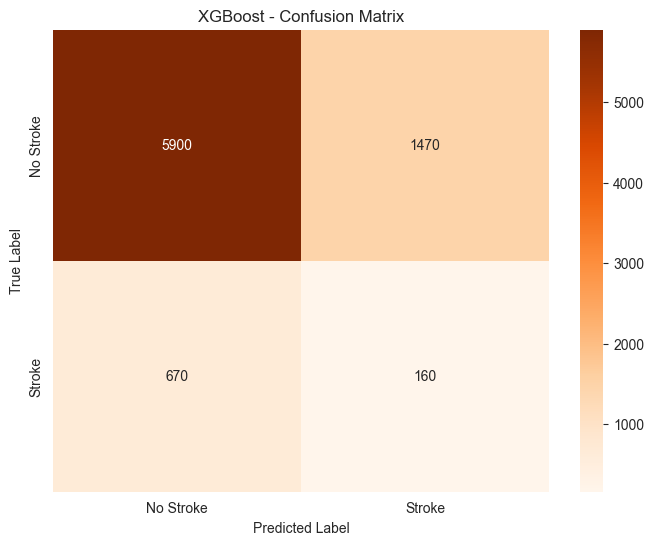

              precision    recall  f1-score   support

   No Stroke       0.90      0.80      0.85      7370
      Stroke       0.10      0.19      0.13       830

    accuracy                           0.74      8200
   macro avg       0.50      0.50      0.49      8200
weighted avg       0.82      0.74      0.77      8200



In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../preprocessed_stroke_data.csv")

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Target distribution: {df['Stroke'].value_counts()}")
print(f"Target distribution (%): {df['Stroke'].value_counts(normalize=True) * 100}")

X = df.drop("Stroke", axis=1)
y = df["Stroke"]

encoders = {}
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set target distribution: {y_train.value_counts()}")
print(f"Test set target distribution: {y_test.value_counts()}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {Counter(y_train)}")
print(f"After SMOTE: {Counter(y_train_resampled)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("\nTraining XGBoost model...")
model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train_scaled, y_train_resampled)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nXGBOOST PERFORMANCE")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))

model_package = {
    'model': model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'encoders': encoders,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'smote_applied': True
}

with open("../models/xgboost.pkl", "wb") as f:
    pickle.dump(model_package, f)
